# **Melanoma Detection Assignment**

**Problem Statement:**
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install augmentor

In [3]:
# Import necessary libraries
import os
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
import numpy as np
import pandas as pd
import PIL
import random

from sklearn.model_selection import train_test_split
from shutil import copy2, rmtree


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import regularizers
import Augmentor
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
from collections import Counter
from keras.regularizers import l2


##**Data Reading/Data Understanding**##
 → Defining the path for train and test images

In [4]:
# Defining the path for train and test images
test_dir = pathlib.Path("/content/drive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")
train_dir = pathlib.Path("/content/drive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

In [5]:
image_count_train = len(list(train_dir.glob('*/*.jpg')))
print("No of images in training data",image_count_train)
image_count_test = len(list(test_dir.glob('*/*.jpg')))
print("No of images in testing data",image_count_test)
print("Total images",image_count_train+image_count_test)

No of images in training data 2239
No of images in testing data 118
Total images 2357


We have a total of 2357 images with 2239 images in the train set and 118 images in the test set.

## **Dataset Creation**

→ Create train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180.

In [6]:
# Define image size and batch size
IMAGE_SIZE = (180, 180)
BATCH_SIZE = 32

### Train and Validation datasets
Let's create a train and validation datasets from the train_dir with an 80-20 split.



In [7]:
# Create training and validation datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"  # One-hot encoding for labels
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Create testing dataset

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical'
)

Found 118 files belonging to 9 classes.


We now have 1792 images in the train dataset, 447 images in the validation dataset and 118 images in the test dataset.

The images are now resized to 180x180 pixels and the batch size is defined as 32.


We also notice that the dataset contains 9 classes that we need to classify.

In [9]:
# List out all the classes of skin cancer and store them in a list.
# Extract class names from the training dataset
class_names = train_dataset.class_names
# Print and store the class names
print("Classes in the dataset:", class_names)

Classes in the dataset: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Here are list of all the skin cancer classes in our dataset.

## **Dataset Visualisation**
→ Create a code to visualize one instance of all the nine classes present in the dataset

Select images form each class

In [10]:
# Initialize an empty dictionary to store one image for each class
selected_images = {}

# Iterate through the entire training dataset
for images, labels in train_dataset:
    # Convert one-hot encoded labels to class indices
    unique_classes = np.argmax(labels, axis=1)

    # Check for each class in the batch
    for idx, label in enumerate(unique_classes):
        class_name = class_names[label]
        if class_name not in selected_images:
            selected_images[class_name] = images[idx]

        # Break early if we have all classes
        if len(selected_images) == len(class_names):
            break
    if len(selected_images) == len(class_names):
        break

# Verify all classes are represented
print("Selected images for classes:", selected_images.keys())

Selected images for classes: dict_keys(['vascular lesion', 'nevus', 'pigmented benign keratosis', 'melanoma', 'dermatofibroma', 'actinic keratosis', 'basal cell carcinoma', 'squamous cell carcinoma', 'seborrheic keratosis'])



Plot the selected images

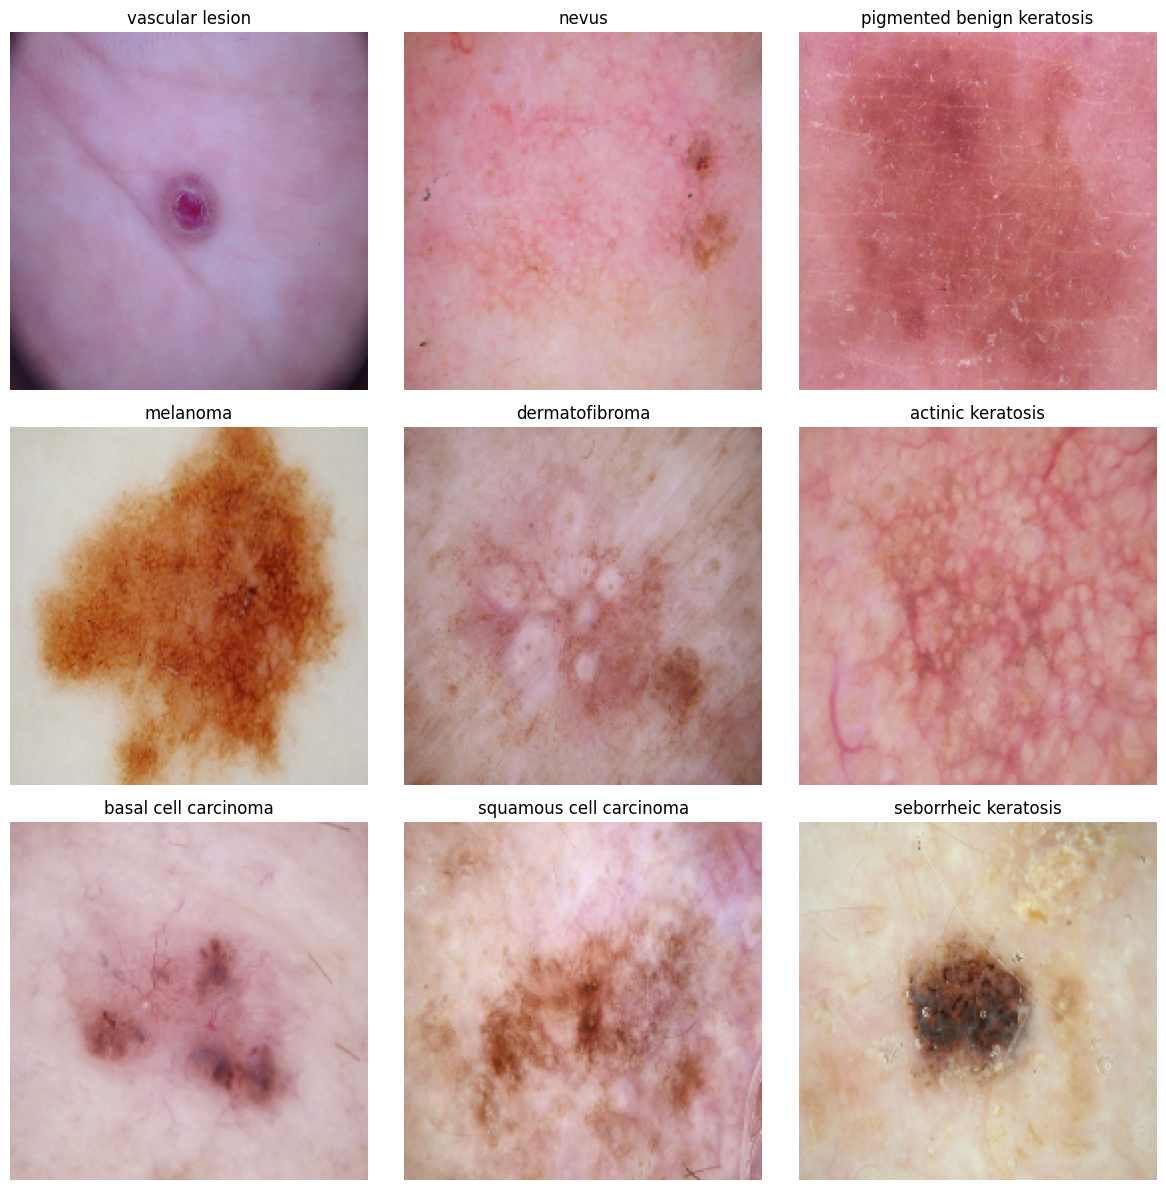

In [11]:
# Plot the images
plt.figure(figsize=(12, 12))
for i, (class_name, img) in enumerate(selected_images.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img.numpy().astype("uint8"))  # Convert tensor to a displayable image
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

The images produce represent each skin cancer types present in our dataset and they are labelled for clarity.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

# Optimize training dataset
train_dataset_optimized = (
    train_dataset
    .cache()
    .shuffle(1000)
    .prefetch(buffer_size=AUTOTUNE)
)

# Optimize validation dataset
validation_dataset_optimized = (
    validation_dataset
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Optimizes the data pipeline for training and validation by using caching, shuffling, and prefetching for

- **Efficiency** : Minimizes data loading bottlenecks during training. (.cache())
- **Randomness** : Ensures the model sees diverse samples in each batch. (.shuffle(1000))
- **Performance** : Improves training speed by overlapping data preparation and model computation. (.prefetch(buffer_size=AUTOTUNE))

## **Model Building & training :**
- Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).
- Choose an appropriate optimiser and loss function for model training
- Train the model for ~20 epochs
- Write your findings after the model fit. You must check if there is any evidence of model overfit or underfit.

## Building

Building a CNN model with the following architecture:
Input Layer (180x180x3)

- Conv2D (32 filters, 3x3 kernel, ReLU)
- MaxPooling2D (2x2)
- Dropout (0.2)
- Conv2D (64 filters, 3x3 kernel, ReLU)
- MaxPooling2D (2x2)
- Dropout (0.2)
- Conv2D (128 filters, 3x3 kernel, ReLU)
- MaxPooling2D (2x2)
- Dropout (0.2)
- Flatten
- Dense (128 neurons, ReLU)
- Dropout (0.5)
- Dense (9 neurons, Softmax)




**Optimizer**: Adam optimizer (commonly used for image classification tasks).

**Loss Function**: Categorical Crossentropy (since this is a multiclass classification problem).

In [13]:


def create_cnn_model(input_shape=(180, 180, 3), num_classes=9):
    model = Sequential()

    # Rescaling Layer
    model.add(Rescaling(1.0 / 255, input_shape=input_shape))  # Normalize pixel values to [0, 1]

    # Block 1: Convolution + MaxPooling
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2: Convolution + MaxPooling
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3: Convolution + MaxPooling
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))  # Use sigmoid for binary classification

    return model

# Instantiate the model
model = create_cnn_model()

# Compile the model
model.compile(optimizer='adam',  # Use 'sgd' with a small learning rate for stricter VGG16 similarity
              loss='categorical_crossentropy',  # Use 'binary_crossentropy' for binary classification
              metrics=['accuracy'])

# Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      15,859,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,001,705 (61.04 MB)

 Trainable params: 16,001,705 (61.04 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:


# Train the model
history = model.fit(
    train_dataset_optimized,
    validation_data=validation_dataset_optimized,
    epochs=20,
    verbose=1
    )

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 61s 236ms/step - accuracy: 0.1994 - loss: 2.1617 - val_accuracy: 0.2260 - val_loss: 2.0065
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2685 - loss: 1.9789 - val_accuracy: 0.3065 - val_loss: 1.9332
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3224 - loss: 1.8824 - val_accuracy: 0.3826 - val_loss: 1.7101
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3880 - loss: 1.6858 - val_accuracy: 0.3781 - val_loss: 1.6590
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3993 - loss: 1.6431 - val_accuracy: 0.4519 - val_loss: 1.5210
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4186 - loss: 1.6073 - val_accuracy: 0.4251 - val_loss: 1.5918
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4037 - loss: 1.6125 - val_accuracy: 0.4116 - val_loss: 1.6132
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4694 - loss: 1.5049 - val_accuracy: 0.4922 -

#### Visualizing training results

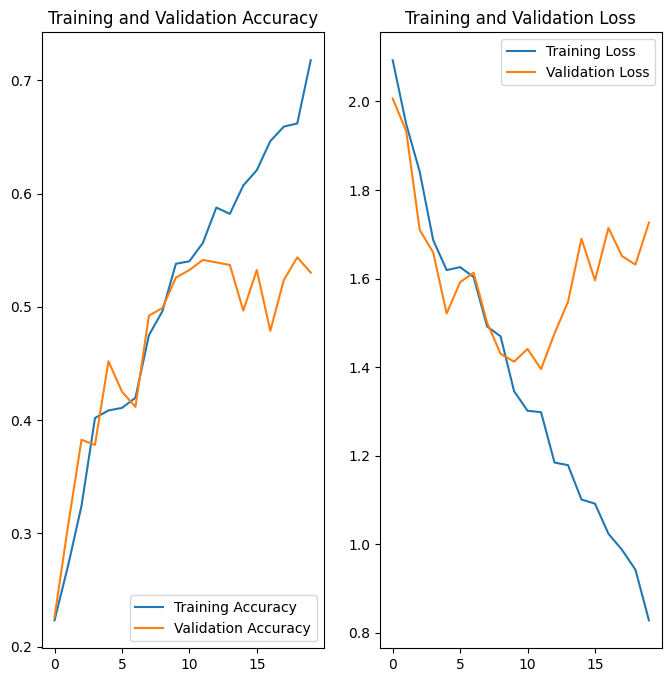

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Check for Overfitting or Underfitting:**

- If validation accuracy is much lower than training accuracy, the model might be overfitting.
- If both accuracies are low, the model might be underfitting.

The model **shows signs of overfitting** as the training accuracy consistently improves, reaching 71.35% by the final epoch, while the validation accuracy plateaus around 53% and starts to degrade slightly. Additionally, the training loss decreases steadily, but the validation loss increases significantly after Epoch 10, further indicating that the model is fitting too closely to the training data and losing generalization ability. To address this, consider implementing strategies such as early stopping, dropout regularization, or reducing model complexity.

## **Data Augmentation**
→ Strategy to resolve underfitting observed.

1. Random Flip (Horizontal and Vertical): invariances to the orientation of the object within the image.
2. Random Rotation:  simulates slight variations in object rotation.
3. Random Zoom: simulates different distances of the object from the camera.
4. Random Contrast: resilient to variations in image lighting conditions.

In [57]:
# Define the data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.4, input_shape=(180, 180, 3)),  # Rotate the image by up to 40%
    tf.keras.layers.RandomZoom(0.3),                               # Zoom into the image by up to 30%
    tf.keras.layers.RandomContrast(0.4),                           # Adjust contrast by up to 40%
])

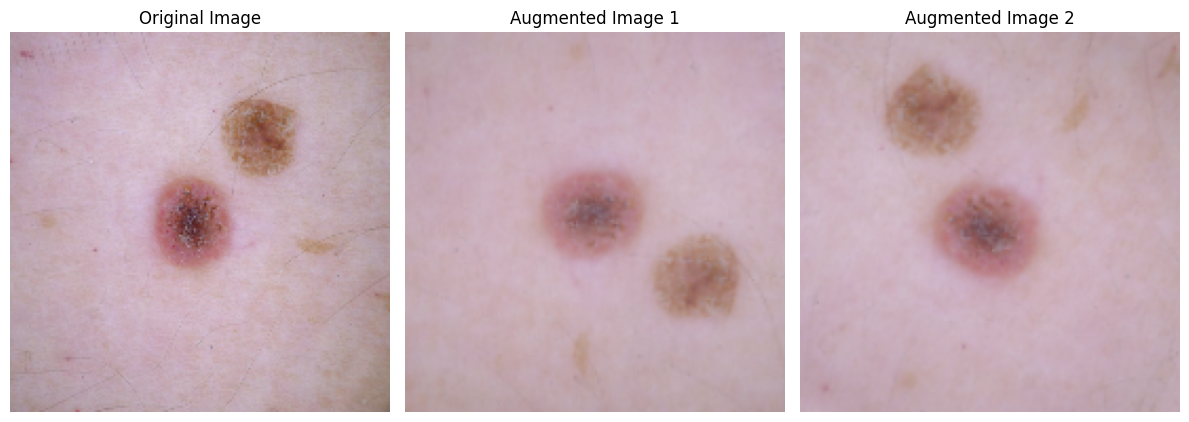

In [59]:
# Get one batch of images from the train dataset
for images, _ in train_dataset.take(1):
    sample_image = images[0]  # Take the first image in the batch

# Apply augmentation to the sample image
augmented_images = [sample_image]
for _ in range(2):  # Generate 2 augmented versions
    augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))  # Add batch dimension
    augmented_images.append(augmented_image[0])

# Plot the original image and augmented images
plt.figure(figsize=(12, 12))
plt.subplot(2, 3, 1)
plt.imshow((sample_image.numpy()).astype(np.uint8))  # Convert to numpy for plotting
plt.title("Original Image")
plt.axis("off")

# Plot the augmented images
for i, aug_img in enumerate(augmented_images[1:], start=1):  # Start from 1 to skip original image
    plt.subplot(2, 3, i + 1)
    plt.imshow((aug_img.numpy()).astype(np.uint8))  # Convert to numpy for plotting
    plt.title(f"Augmented Image {i}")
    plt.axis("off")


plt.tight_layout()
plt.show()

As can be seen in the above images, the augmented images vary from the original image implementing our strategy by changing the contrast, fliping, rotation and size of the object.

### Data Augmented Model

In [60]:

def create_cnn_model_augmentation(input_shape=(180, 180, 3), num_classes=9):
    model = Sequential()

    # Data Augmentation layer
    data_augmentation,

    # Rescaling Layer
    model.add(Rescaling(1.0 / 255, input_shape=input_shape))  # Normalize pixel values to [0, 1]

    # Block 1: Convolution + MaxPooling
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2: Convolution + MaxPooling
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3: Convolution + MaxPooling
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))  # Use sigmoid for binary classification

    return model

# Instantiate the model

model = create_cnn_model_augmentation()

# Compile the model
model.compile(optimizer='adam',  # Use 'sgd' with a small learning rate for stricter VGG16 similarity
              loss='categorical_crossentropy',  # Use 'binary_crossentropy' for binary classification
              metrics=['accuracy'])

# Summary
model.summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      15,859,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,001,705 (61.04 MB)

 Trainable params: 16,001,705 (61.04 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:

# Train the model
history = model.fit(
    train_dataset_optimized,
    validation_data=validation_dataset_optimized,
    epochs=20,
    verbose=1
    )

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.2034 - loss: 2.1815 - val_accuracy: 0.3378 - val_loss: 1.8762
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3113 - loss: 1.8727 - val_accuracy: 0.3937 - val_loss: 1.6414
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3544 - loss: 1.7140 - val_accuracy: 0.4161 - val_loss: 1.6950
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3881 - loss: 1.6704 - val_accuracy: 0.4318 - val_loss: 1.6366
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4052 - loss: 1.6304 - val_accuracy: 0.4340 - val_loss: 1.6525
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4603 - loss: 1.5450 - val_accuracy: 0.4855 - val_loss: 1.5385
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5040 - loss: 1.4446 - val_accuracy: 0.5123 - val_loss: 1.4295
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3981 - loss: 1.7122 - val_accuracy: 0.5190 - v

#### Visualizing training results

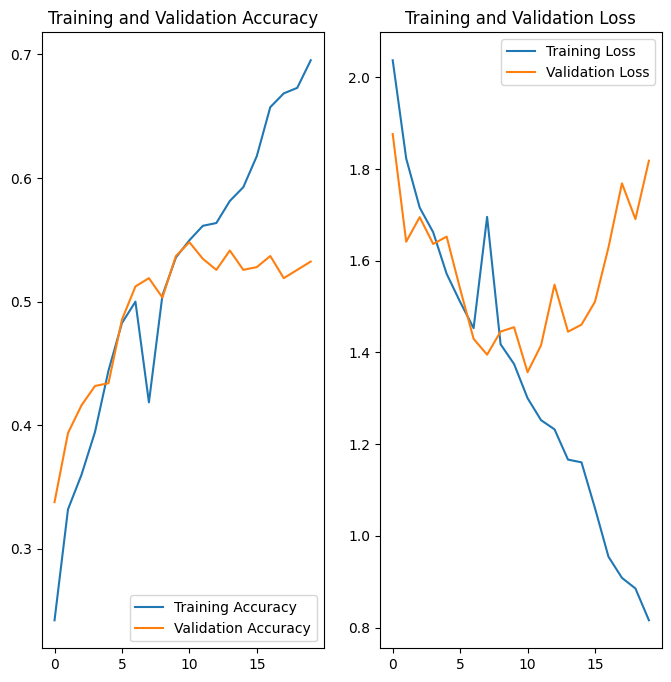

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The use of data augmentation has **somewhat alleviated the overfitting** observed in the initial model, as indicated by a better alignment of training and validation accuracy in the earlier epochs. However, the validation loss starts increasing significantly after Epoch 10, and the validation accuracy plateaus around 53%, suggesting the issue of **overfitting is not entirely resolved.**

## Class Imbalance

**Class distribution**: Examine the current class distribution in the training dataset
- Which class has the least number of samples?
- Which classes dominate the data in terms of the proportionate number of samples?

In [63]:
# Define paths
train_data_dir = train_dir  # Replace with the path to your training dataset
augmented_data_dir = "/content/drive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented data new 1"


In [64]:

# Extract class names from folder names
class_names = sorted(os.listdir(train_dir))

# Initialize dictionary for class counts
class_counts = {class_name: 0 for class_name in class_names}

# Count images in each class folder
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

# Class distribution
class_distribution = class_counts

# Find least-represented and dominant classes
least_represented_class = min(class_distribution, key=class_distribution.get)
dominant_class = max(class_distribution, key=class_distribution.get)

print("Class Distribution:", class_distribution)
print(f"Least Represented Class: {least_represented_class} ({class_distribution[least_represented_class]} samples)")
print(f"Dominant Class: {dominant_class} ({class_distribution[dominant_class]} samples)")


Class Distribution: {'actinic keratosis': 114, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'melanoma': 438, 'nevus': 357, 'pigmented benign keratosis': 462, 'seborrheic keratosis': 77, 'squamous cell carcinoma': 181, 'vascular lesion': 139}
Least Represented Class: seborrheic keratosis (77 samples)
Dominant Class: pigmented benign keratosis (462 samples)


We found that the train dataset had heavy class imbalance with
- Least Represented Class: seborrheic keratosis (77 samples)
- Dominant Class: pigmented benign keratosis (462 samples)

**Handling class imbalances**: Rectify class imbalances present in the training dataset with Augmentor library.

Let's ensure that there are **500 samples** of each class by generating new images based on data augmentation.

In [66]:

# Class distribution dictionary from previous analysis convert to float
class_distribution = {key: int(value) for key, value in class_distribution.items()}

# Define the target number of samples (match the dominant class)
target_samples = 500

# Augment each class to match the target count
for class_name, current_count in class_distribution.items():
    if current_count < target_samples:
        # Path to the class folder
        class_dir = os.path.join(train_data_dir, class_name)

        # Create an Augmentor pipeline
        p = Augmentor.Pipeline(source_directory=class_dir, output_directory=os.path.join(augmented_data_dir, class_name))

        # Random rotation by up to 40%
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

        # Random zoom with a focus on retaining 70% to 100% of the area
        p.zoom_random(probability=0.3, percentage_area=0.7)

        # Random contrast adjustments by up to 40% deviation
        p.random_contrast(probability=0.4, min_factor=0.6, max_factor=1.4)

        # Sample enough images to meet the target count
        p.sample(target_samples - current_count)

print("Augmentation completed. Check the `augmented_data_new_1` directory.")




Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented data new 1/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7813107D7090>: 100%|██████████| 386/386 [00:03<00:00, 112.10 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented data new 1/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7813103B6490>: 100%|██████████| 124/124 [00:01<00:00, 106.08 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented data new 1/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x781493C2BB50>: 100%|██████████| 405/405 [00:03<00:00, 107.55 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented data new 1/melanoma.

Processing <PIL.Image.Image image mode=RGB size=1936x1296 at 0x781310647210>: 100%|██████████| 62/62 [00:02<00:00, 25.53 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented data new 1/nevus.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x78131062FFD0>: 100%|██████████| 143/143 [00:04<00:00, 31.43 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented data new 1/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7813103A2890>: 100%|██████████| 38/38 [00:00<00:00, 102.03 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented data new 1/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7813105BFC90>: 100%|██████████| 423/423 [00:06<00:00, 65.24 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented data new 1/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78133E2EDD90>: 100%|██████████| 319/319 [00:02<00:00, 108.01 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented data new 1/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7812ECFD1390>: 100%|██████████| 361/361 [00:03<00:00, 106.68 Samples/s]

Augmentation completed. Check the `augmented_data_new_1` directory.


In [67]:
# Combine the augmented data with the original data
combined_data_dir = "combined_training_data_again"
os.makedirs(combined_data_dir, exist_ok=True)

# Copy original and augmented images into the combined directory
import shutil

for class_name in class_distribution.keys():
    # Ensure the combined directory has a folder for each class
    os.makedirs(os.path.join(combined_data_dir, class_name), exist_ok=True)

    # Copy original images
    original_class_dir = os.path.join(train_data_dir, class_name)
    for file_name in os.listdir(original_class_dir):
        shutil.copy(os.path.join(original_class_dir, file_name), os.path.join(combined_data_dir, class_name))

    # Copy augmented images
    augmented_class_dir = os.path.join(augmented_data_dir, class_name)
    for file_name in os.listdir(augmented_class_dir):
        shutil.copy(os.path.join(augmented_class_dir, file_name), os.path.join(combined_data_dir, class_name))

print("Combined data directory created at:", combined_data_dir)


Combined data directory created at: combined_training_data_again


Now we have sucessfully generated the augmented images and merged them with the training set.

In [68]:
# Dictionary to hold the class names and image counts
class_image_counts = {}

# Iterate through each subdirectory in the combined data directory
for class_name in os.listdir(combined_data_dir):
    class_path = os.path.join(combined_data_dir, class_name)
    if os.path.isdir(class_path):
        # Count the number of image files in the current class subdirectory
        num_images = len([file for file in os.listdir(class_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_image_counts[class_name] = num_images

# Print the image counts for each class
for class_name, count in class_image_counts.items():
    print(f"Class '{class_name}': {count} images")

Class 'pigmented benign keratosis': 500 images
Class 'basal cell carcinoma': 500 images
Class 'dermatofibroma': 500 images
Class 'squamous cell carcinoma': 500 images
Class 'nevus': 500 images
Class 'vascular lesion': 500 images
Class 'seborrheic keratosis': 500 images
Class 'actinic keratosis': 500 images
Class 'melanoma': 500 images


We have now 500 samples for each class after handling class imbalance.

In [69]:
# Load the combined dataset
BATCH_SIZE = 32
train_dataset_balanced = image_dataset_from_directory(
    combined_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode="categorical",
    image_size=(180, 180),
    batch_size=BATCH_SIZE,
)

validation_dataset_balanced = image_dataset_from_directory(
    combined_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(180, 180),
    batch_size=BATCH_SIZE,
)

print("Balanced training and validation datasets created.")


Found 4500 files belonging to 9 classes.
Using 3600 files for training.
Found 4500 files belonging to 9 classes.
Using 900 files for validation.
Balanced training and validation datasets created.


In [70]:
AUTOTUNE = tf.data.AUTOTUNE

# Optimize training dataset
train_dataset_optimized_balanced = (
    train_dataset_balanced
    .cache()
    .shuffle(1000)
    .prefetch(buffer_size=AUTOTUNE)
)

# Optimize validation dataset
validation_dataset_optimized_balanced = (
    validation_dataset_balanced
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

### Class Balanced Model

In [71]:
def create_cnn_model_balanced(input_shape=(180, 180, 3), num_classes=9):
    model = Sequential()

    # Rescaling Layer
    model.add(Rescaling(1.0 / 255, input_shape=input_shape))  # Normalize pixel values to [0, 1]

    # Block 1: Convolution + MaxPooling
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2: Convolution + MaxPooling
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3: Convolution + MaxPooling
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Instantiate the model
model = create_cnn_model_balanced()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │      15,859,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,001,705 (61.04 MB)

 Trainable params: 16,001,705 (61.04 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:


# Train the model
history = model.fit(
    train_dataset_optimized_balanced,
    validation_data=validation_dataset_optimized_balanced,
    epochs=30,
    verbose=1
    )

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.1630 - loss: 2.3210 - val_accuracy: 0.2822 - val_loss: 1.7936
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3007 - loss: 1.7538 - val_accuracy: 0.3644 - val_loss: 1.5633
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3634 - loss: 1.6200 - val_accuracy: 0.3922 - val_loss: 1.5225
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3981 - loss: 1.5619 - val_accuracy: 0.3944 - val_loss: 1.6312
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4240 - loss: 1.4852 - val_accuracy: 0.4378 - val_loss: 1.4785
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4504 - loss: 1.4181 - val_accuracy: 0.4633 - val_loss: 1.4055
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4428 - loss: 1.4036 - val_accuracy: 0.4833 - val_loss: 1.3794
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4505 - loss: 1.4403 - val_acc

#### Visualizing training results

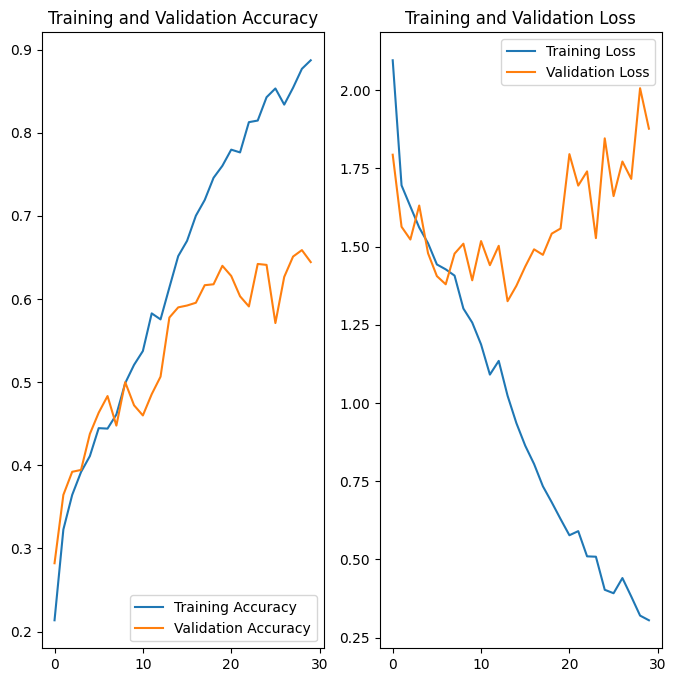

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After addressing class imbalance, the model shows **significant improvement in both training and validation accuracy**, reaching 89.48% and 64.44%, respectively, by the 30th epoch.

However, the validation loss remains relatively high and fluctuates in later epochs, **suggesting some overfitting**.

While the class imbalance adjustment has improved class representation and overall performance, further refinement in the model architecture or regularization techniques may be necessary to enhance generalization.


## Furthur improvements

### Early stopping and Learning rate scheduler

1. **Early Stopping**: This will stop training when the validation performance stops improving, avoiding overfitting and saving training time.
2. **Learning Rate Scheduler**: This dynamically adjusts the learning rate during training to improve convergence.

In [74]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_cnn_model_balanced(input_shape=(180, 180, 3), num_classes=9):
    model = Sequential()

    # Rescaling Layer
    model.add(Rescaling(1.0 / 255, input_shape=input_shape))  # Normalize pixel values to [0, 1]

    # Block 1: Convolution + MaxPooling
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2: Convolution + MaxPooling
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3: Convolution + MaxPooling
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Instantiate the model
model = create_cnn_model_balanced()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)




Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │      15,859,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,001,705 (61.04 MB)

 Trainable params: 16,001,705 (61.04 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:

# Train the model
history = model.fit(
    train_dataset_optimized_balanced,
    validation_data=validation_dataset_optimized_balanced,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
    )

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.1105 - loss: 2.2278 - val_accuracy: 0.1200 - val_loss: 2.2317 - learning_rate: 0.0010
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1423 - loss: 2.1584 - val_accuracy: 0.2822 - val_loss: 1.8143 - learning_rate: 0.0010
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2406 - loss: 1.8963 - val_accuracy: 0.3411 - val_loss: 1.6340 - learning_rate: 0.0010
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3687 - loss: 1.6694 - val_accuracy: 0.3200 - val_loss: 1.7668 - learning_rate: 0.0010
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3927 - loss: 1.6171 - val_accuracy: 0.4111 - val_loss: 1.5776 - learning_rate: 0.0010
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4131 - loss: 1.5033 - val_accuracy: 0.4433 - val_loss: 1.4204 - learning_rate: 0.0010
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4630 - loss: 1.

#### Visualizing training results

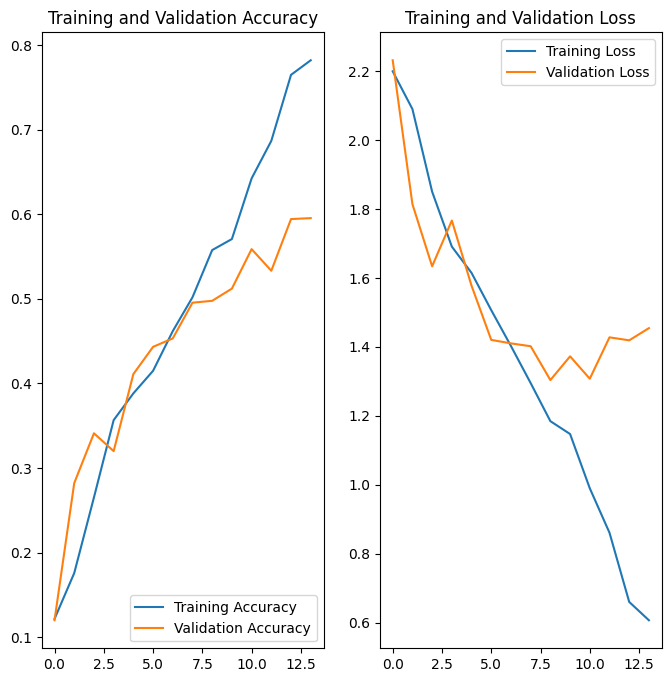

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(14)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model shows steady improvement in accuracy and loss for both the training and validation sets during the initial epochs, with significant performance gains up to Epoch 12. Early stopping, combined with the learning rate scheduler, allowed the model to **reduce overfitting**, as seen by **smoother convergence** of validation metrics, though a slight validation loss plateau was observed post Epoch 11. This strategy optimized learning dynamics, achieving a training accuracy of 78.99% and validation accuracy of 59.56%, with acceptable validation loss stabilization at a lower learning rate in the later epochs.

### L2 regularization

In [94]:
def create_cnn_model_with_l2(input_shape=(180, 180, 3), num_classes=9, l2_strength=0.0001):
    model = Sequential()

    # Rescaling Layer
    model.add(Rescaling(1.0 / 255, input_shape=input_shape))  # Normalize pixel values to [0, 1]

    # Block 1: Convolution + MaxPooling
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_strength)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_strength)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2: Convolution + MaxPooling
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_strength)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_strength)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3: Convolution + MaxPooling
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_strength)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_strength)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Instantiate the model
model = create_cnn_model_with_l2()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1e-6)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_13 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_66 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_67 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_69 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 256)                 │      15,859,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,001,705 (61.04 MB)

 Trainable params: 16,001,705 (61.04 MB)

 Non-trainable params: 0 (0.00 B)

In [95]:
# Train the model
history = model.fit(
    train_dataset_optimized_balanced,
    validation_data=validation_dataset_optimized_balanced,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
    )

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.1513 - loss: 2.3080 - val_accuracy: 0.3122 - val_loss: 1.9041 - learning_rate: 0.0010
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2729 - loss: 1.9033 - val_accuracy: 0.4011 - val_loss: 1.5997 - learning_rate: 0.0010
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3476 - loss: 1.7128 - val_accuracy: 0.4222 - val_loss: 1.5526 - learning_rate: 0.0010
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3880 - loss: 1.6484 - val_accuracy: 0.3900 - val_loss: 1.5506 - learning_rate: 0.0010
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4008 - loss: 1.5831 - val_accuracy: 0.3867 - val_loss: 1.5840 - learning_rate: 0.0010
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4168 - loss: 1.5585 - val_accuracy: 0.4322 - val_loss: 1.4843 - learning_rate: 0.0010
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4105 - loss: 1

#### Visualizing training results

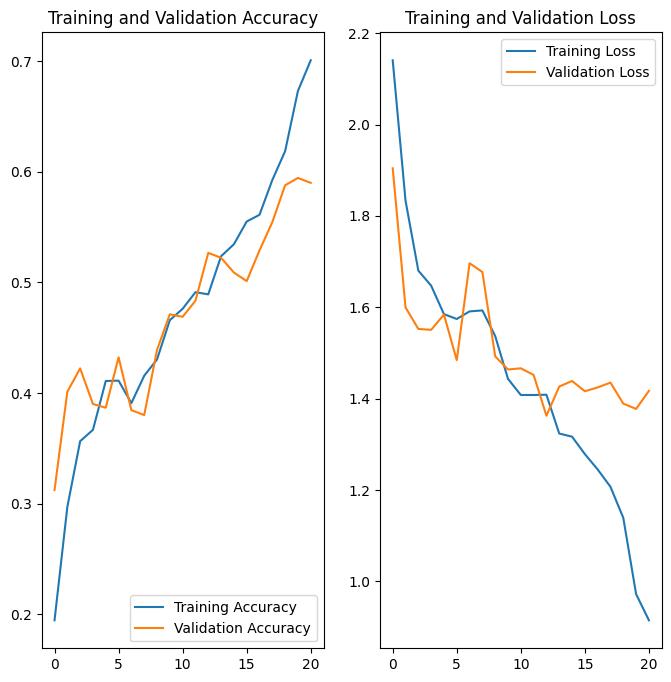

In [97]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(21)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model showed significant improvement in training accuracy, rising from 15% to 70% by epoch 21, and validation accuracy increased from 31% to 59% during the same period, indicating better generalization. The validation loss stabilized, and the learning rate reduction strategy helped maintain steady progress after epoch 20.

### Batch Normalization and Drop out

In [104]:
from tensorflow.keras.layers import BatchNormalization

def create_cnn_model_with_bn(input_shape=(180, 180, 3), num_classes=9, l2_strength=0.001, dropout_rate=0.5):
    model = Sequential()

    # Rescaling Layer
    model.add(Rescaling(1.0 / 255, input_shape=input_shape))  # Normalize pixel values to [0, 1]

    # Block 1: Convolution + BatchNormalization + MaxPooling + Dropout
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(l2_strength)))
    model.add(BatchNormalization())  # Add BatchNormalization
    model.add(Activation('relu'))  # Apply activation after normalization
    model.add(Dropout(dropout_rate))  # Add Dropout
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(l2_strength)))
    model.add(BatchNormalization())  # Add BatchNormalization
    model.add(Activation('relu'))  # Apply activation after normalization
    model.add(Dropout(dropout_rate))  # Add Dropout
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2: Convolution + BatchNormalization + MaxPooling + Dropout
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(l2_strength)))
    model.add(BatchNormalization())  # Add BatchNormalization
    model.add(Activation('relu'))  # Apply activation after normalization
    model.add(Dropout(dropout_rate))  # Add Dropout
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(l2_strength)))
    model.add(BatchNormalization())  # Add BatchNormalization
    model.add(Activation('relu'))  # Apply activation after normalization
    model.add(Dropout(dropout_rate))  # Add Dropout
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3: Convolution + BatchNormalization + MaxPooling + Dropout
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(l2_strength)))
    model.add(BatchNormalization())  # Add BatchNormalization
    model.add(Activation('relu'))  # Apply activation after normalization
    model.add(Dropout(dropout_rate))  # Add Dropout
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, kernel_regularizer=l2(l2_strength)))
    model.add(BatchNormalization())  # Add BatchNormalization
    model.add(Activation('relu'))  # Apply activation after normalization
    model.add(Dropout(dropout_rate))  # Add Dropout
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Instantiate the model
model = create_cnn_model_with_bn()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_17 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_85 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_86 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_87 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_88 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,004,009 (61.05 MB)

 Trainable params: 16,002,857 (61.05 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [105]:
# Train the model
history = model.fit(
    train_dataset_optimized_balanced,
    validation_data=validation_dataset_optimized_balanced,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
    )

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 100ms/step - accuracy: 0.2698 - loss: 3.2598 - val_accuracy: 0.1111 - val_loss: 3.9737 - learning_rate: 0.0010
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4123 - loss: 2.6246 - val_accuracy: 0.1067 - val_loss: 3.6741 - learning_rate: 0.0010
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4694 - loss: 2.2880 - val_accuracy: 0.1211 - val_loss: 3.5122 - learning_rate: 0.0010
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4892 - loss: 2.0898 - val_accuracy: 0.1067 - val_loss: 3.5881 - learning_rate: 0.0010
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5018 - loss: 1.9797 - val_accuracy: 0.1089 - val_loss: 3.4396 - learning_rate: 0.0010
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5311 - loss: 1.9279 - val_accuracy: 0.1144 - val_loss: 3.2189 - learning_rate: 0.0010
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5366 - loss: 

#### Visualizing training results

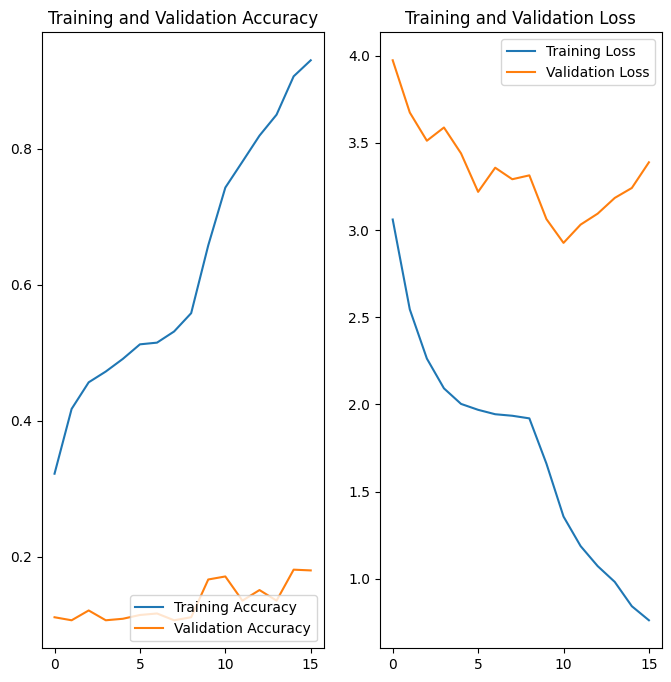

In [106]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(16)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Batch Normalization can make a model more expressive, allowing it to learn more complex patterns. However, if the model is too large or complex relative to the amount of data, batch normalization may inadvertently make it more prone to overfitting by allowing it to **"memorize" rather than generalize**. This can result in better performance on the training data but poor generalization to validation data.

**Early stopping and learning rate scheduler may not be quick enough to prevent overfitting**, especially if the **model is complex and the data is insufficient**, or if **overfitting begins early** and these techniques are based on gradual loss improvements.

### Simplified Architecture

It’s essential to simplify the model architecture to counteract overfitting when batch normalization is applied.

In [123]:
def create_cnn_model_simple(input_shape=(180, 180, 3), num_classes=9, l2_strength=0.0001):
    model = Sequential()

    # Rescaling Layer
    model.add(Rescaling(1.0 / 255, input_shape=input_shape))  # Normalize pixel values to [0, 1]

    # Block 1: Convolution + BatchNormalization + MaxPooling
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_strength)))
    #model.add(BatchNormalization())  # Add BatchNormalization
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2: Convolution + BatchNormalization + MaxPooling
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_strength)))
    #model.add(BatchNormalization())  # Add BatchNormalization
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3: Convolution + BatchNormalization + MaxPooling
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_strength)))
    #model.add(BatchNormalization())  # Add BatchNormalization
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_strength)))
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Instantiate the model
model = create_cnn_model_simple()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1e-6)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_26 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_109 (Conv2D)                  │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_73 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_110 (Conv2D)                  │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_74 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_111 (Conv2D)                  │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_75 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_26 (Flatten)                 │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 256)                 │      15,859,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,955,529 (60.87 MB)

 Trainable params: 15,955,529 (60.87 MB)

 Non-trainable params: 0 (0.00 B)

In [124]:
# Train the model
history = model.fit(
    train_dataset_optimized_balanced,
    validation_data=validation_dataset_optimized_balanced,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
    )

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.2048 - loss: 2.2884 - val_accuracy: 0.3867 - val_loss: 1.7020 - learning_rate: 0.0010
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3802 - loss: 1.6534 - val_accuracy: 0.4022 - val_loss: 1.5757 - learning_rate: 0.0010
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4136 - loss: 1.5762 - val_accuracy: 0.4678 - val_loss: 1.4683 - learning_rate: 0.0010
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4575 - loss: 1.4683 - val_accuracy: 0.4389 - val_loss: 1.4567 - learning_rate: 0.0010
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4823 - loss: 1.4160 - val_accuracy: 0.5178 - val_loss: 1.3970 - learning_rate: 0.0010
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5079 - loss: 1.3836 - val_accuracy: 0.5022 - val_loss: 1.3780 - learning_rate: 0.0010
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5393 - loss: 1.3215 -

#### Visualizing training results

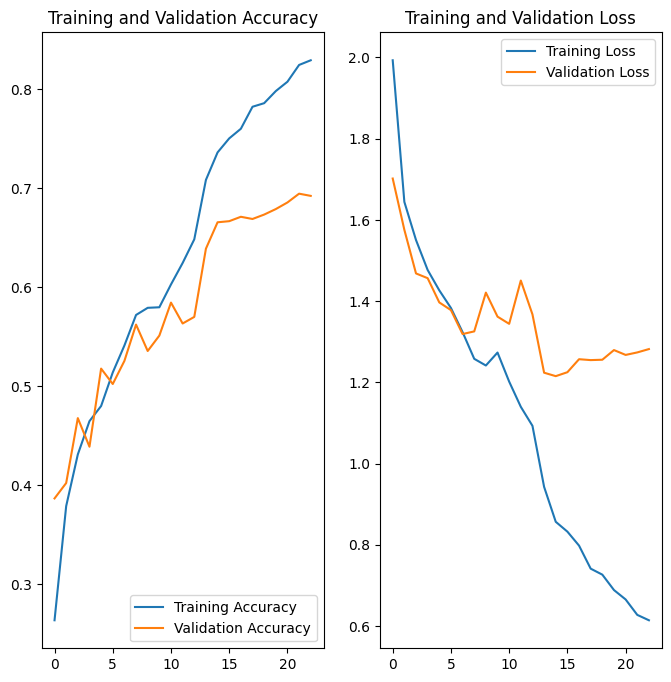

In [126]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(23)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Although there is a steady increase in the model's performance overall, there is still some amount of overfitting that can be observed.

# Concluding Remarks


The results from the model training, especially with the augmented dataset, reflect several critical observations and limitations that must be considered:

1. **Overfitting Risk**: The ***over-augmentation of the less-represented classes***, such as seborrheic keratosis and dermatofibroma, led to an excessive generation of similar images. This strategy, while aiming to balance class distributions, resulted in the model potentially ***memorizing these augmented variations rather than learning to generalize from them***. Consequently, this overfitting issue may impair the model's performance on unseen data, where the augmented images’ specific variations might not appear.

2. **Class Distribution Integrity**: By artificially augmenting the dataset to match the target class size of 500 for the smaller classes, the true underlying distribution of diseases was distorted. ***This balancing act, although effective in terms of class frequency, misrepresented the natural distribution of conditions***, which is important for the model's learning. The balanced class distribution could create an unrealistic expectation for the model during inference, ultimately leading to skewed predictions that may not reflect the actual prevalence of these conditions in the real world.

3. **Increased Complexity with Similar Data**: The **over-augmentation of the data introduced many highly similar images, increasing the overall dataset size but without adding true diversity**. This can lead to unnecessary model complexity, as the model is now forced to process a large volume of nearly identical images. This could make the model less efficient and result in a reduction of its ability to differentiate between subtle class features, thus affecting its predictive performance.

## Limitations
The challenges encountered during the modeling process highlight several key limitations:

1. **Small Dataset Size**: With only 2,239 images in total, the dataset is relatively small for a complex task like image classification. In such cases, deep learning models often struggle to learn meaningful, generalized features, which increases the risk of overfitting. The limited data exacerbates this issue, especially in the case of highly imbalanced classes.

2. **Class Imbalance**: Despite efforts to address class imbalance through over-sampling, the dataset still had a skewed distribution, with classes like pigmented benign keratosis vastly outnumbering others. This imbalance tends to lead to a bias in model predictions towards the dominant classes, diminishing the model’s ability to accurately predict underrepresented conditions.

3. **Limited Data Diversity**: The augmentation process, although effective at increasing sample size, lacked significant diversity. Augmented images often replicate specific transformations, which may not fully capture the true variations found in real-world scenarios. Without true diversity in data, the model’s ability to generalize to unseen, diverse images becomes limited.